## Advanced EDA Notebook - Section 1: Setup and Data Loading

Building on the foundational EDA, this notebook focuses on advanced statistical analysis, customer segmentation, and deeper pattern exploration to support predictive modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# FNB brand colors
fnb_blue = '#003D7A'
fnb_gold = '#FFB81C'
fnb_gray = '#53565A'
fnb_light_blue = '#0076C0'

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
sns.set_palette([fnb_blue, fnb_gold, fnb_gray, fnb_light_blue])

In [2]:
# Load dataset
df = pd.read_csv("Churn_Modelling_SA_FNB.csv")

print(f"Dataset loaded: {df.shape[0]:,} customers, {df.shape[1]} features")
print(f"Baseline churn rate: {df['Churned'].mean():.1%}")

Dataset loaded: 10,000 customers, 43 features
Baseline churn rate: 20.4%


In [3]:
# Create churned and retained subsets for analysis
df_churned = df[df["Churned"] == 1].copy()
df_retained = df[df["Churned"] == 0].copy()

print(f"\nChurned: {len(df_churned):,} customers")
print(f"Retained: {len(df_retained):,} customers")


Churned: 2,037 customers
Retained: 7,963 customers


This notebook extends the initial EDA by applying statistical rigor to the patterns identified. The analysis will focus on hypothesis testing, effect size quantification, customer value segmentation, and interaction effects between key churn drivers.

Previous findings to validate statistically:
- Age difference (7.4 years older for churned customers)
- Geographic concentration (Limpopo, Eastern Cape, Mpumalanga)
- Product complexity paradox (U-shaped curve)
- Gender disparity (8.6pp difference)
- Personal loan crisis (85.9% churn)

Next steps involve calculating effect sizes, testing for statistical significance with appropriate methods, and identifying customer segments for targeted retention strategies.

## Section 2: Customer Value Segmentation (RFM-Style)

Creating customer value segments using an adapted RFM framework to identify which customer tiers are most at risk and quantify revenue exposure. This segmentation will inform prioritization of retention efforts.

RFM components adapted for banking:
- Recency (R): Tenure (relationship length)
- Frequency (F): Product count (engagement depth)
- Monetary (M): Account balance (customer value)

In [4]:
# R Score: Tenure quartiles (relationship recency/maturity)
try:
    df["R_Score"] = pd.qcut(df["Tenure"], q=4, labels=False, duplicates="drop") + 1
except Exception:
    df["R_Score"] = pd.cut(df["Tenure"], bins=4, labels=False) + 1

print("R Score (Tenure) distribution:")
print(df["R_Score"].value_counts().sort_index())

R Score (Tenure) distribution:
R_Score
1    3505
2    2001
3    1995
4    2499
Name: count, dtype: int64


In [5]:
# F Score: Product count (banking engagement depth)
df["F_Score"] = pd.cut(df["NumOfProducts"], bins=[0, 1, 2, 3, 5], labels=False) + 1

print("\nF Score (Product Count) distribution:")
print(df["F_Score"].value_counts().sort_index())


F Score (Product Count) distribution:
F_Score
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


In [6]:
# M Score: Balance quartiles (monetary value)
try:
    df["M_Score"] = pd.qcut(df["Balance_ZAR"].rank(method="first"), q=4, labels=False, duplicates="drop") + 1
except Exception:
    df["M_Score"] = pd.cut(df["Balance_ZAR"], bins=4, labels=False) + 1

print("\nM Score (Balance) distribution:")
print(df["M_Score"].value_counts().sort_index())


M Score (Balance) distribution:
M_Score
1    2500
2    2500
3    2500
4    2500
Name: count, dtype: int64


In [7]:
# Create composite RFM segment
df["RFM_Segment"] = (df["R_Score"].astype(str) +
                     df["F_Score"].astype(str) +
                     df["M_Score"].astype(str))

# Aggregate into customer value tiers
df["Customer_Value"] = pd.cut(
    df["R_Score"] + df["F_Score"] + df["M_Score"],
    bins=[0, 4, 7, 9, 12],
    labels=["Low Value", "Medium Value", "High Value", "VIP"]
)

print("\nCustomer Value Tier Distribution:")
print(df["Customer_Value"].value_counts())


Customer Value Tier Distribution:
Customer_Value
Medium Value    6155
High Value      2241
Low Value       1339
VIP              265
Name: count, dtype: int64


In [8]:
# Segment analysis
segment_analysis = df.groupby("Customer_Value").agg({
    "Churned": ["count", "mean"],
    "Balance_ZAR": "mean",
    "NumOfProducts": "mean",
    "Age": "mean"
}).round(2)

segment_analysis.columns = ["Count", "Churn_Rate", "Avg_Balance", "Avg_Products", "Avg_Age"]
segment_analysis["Churn_Rate_%"] = (segment_analysis["Churn_Rate"] * 100).round(1)

print("\nCustomer Value Segments:")
print(segment_analysis[["Count", "Churn_Rate_%", "Avg_Balance", "Avg_Products", "Avg_Age"]])


Customer Value Segments:
                Count  Churn_Rate_%  Avg_Balance  Avg_Products  Avg_Age
Customer_Value                                                         
Low Value        1339          20.0    378215.85          1.43    39.31
Medium Value     6155          19.0   1465800.45          1.51    38.81
High Value       2241          24.0   2395261.53          1.55    38.88
VIP               265          35.0   2956201.64          2.38    39.83


In [9]:
# Calculate revenue at risk
df["Revenue_at_Risk"] = df["Balance_ZAR"] * df["Churned"]

revenue_at_risk_summary = df.groupby("Customer_Value")["Revenue_at_Risk"].sum() / 1_000_000
print("\nRevenue at Risk by Segment (Millions ZAR):")
print(revenue_at_risk_summary.round(1))


Revenue at Risk by Segment (Millions ZAR):
Customer_Value
Low Value        110.2
Medium Value    2087.9
High Value      1345.4
VIP              261.0
Name: Revenue_at_Risk, dtype: float64



Saved: advanced_eda_customer_segmentation.png


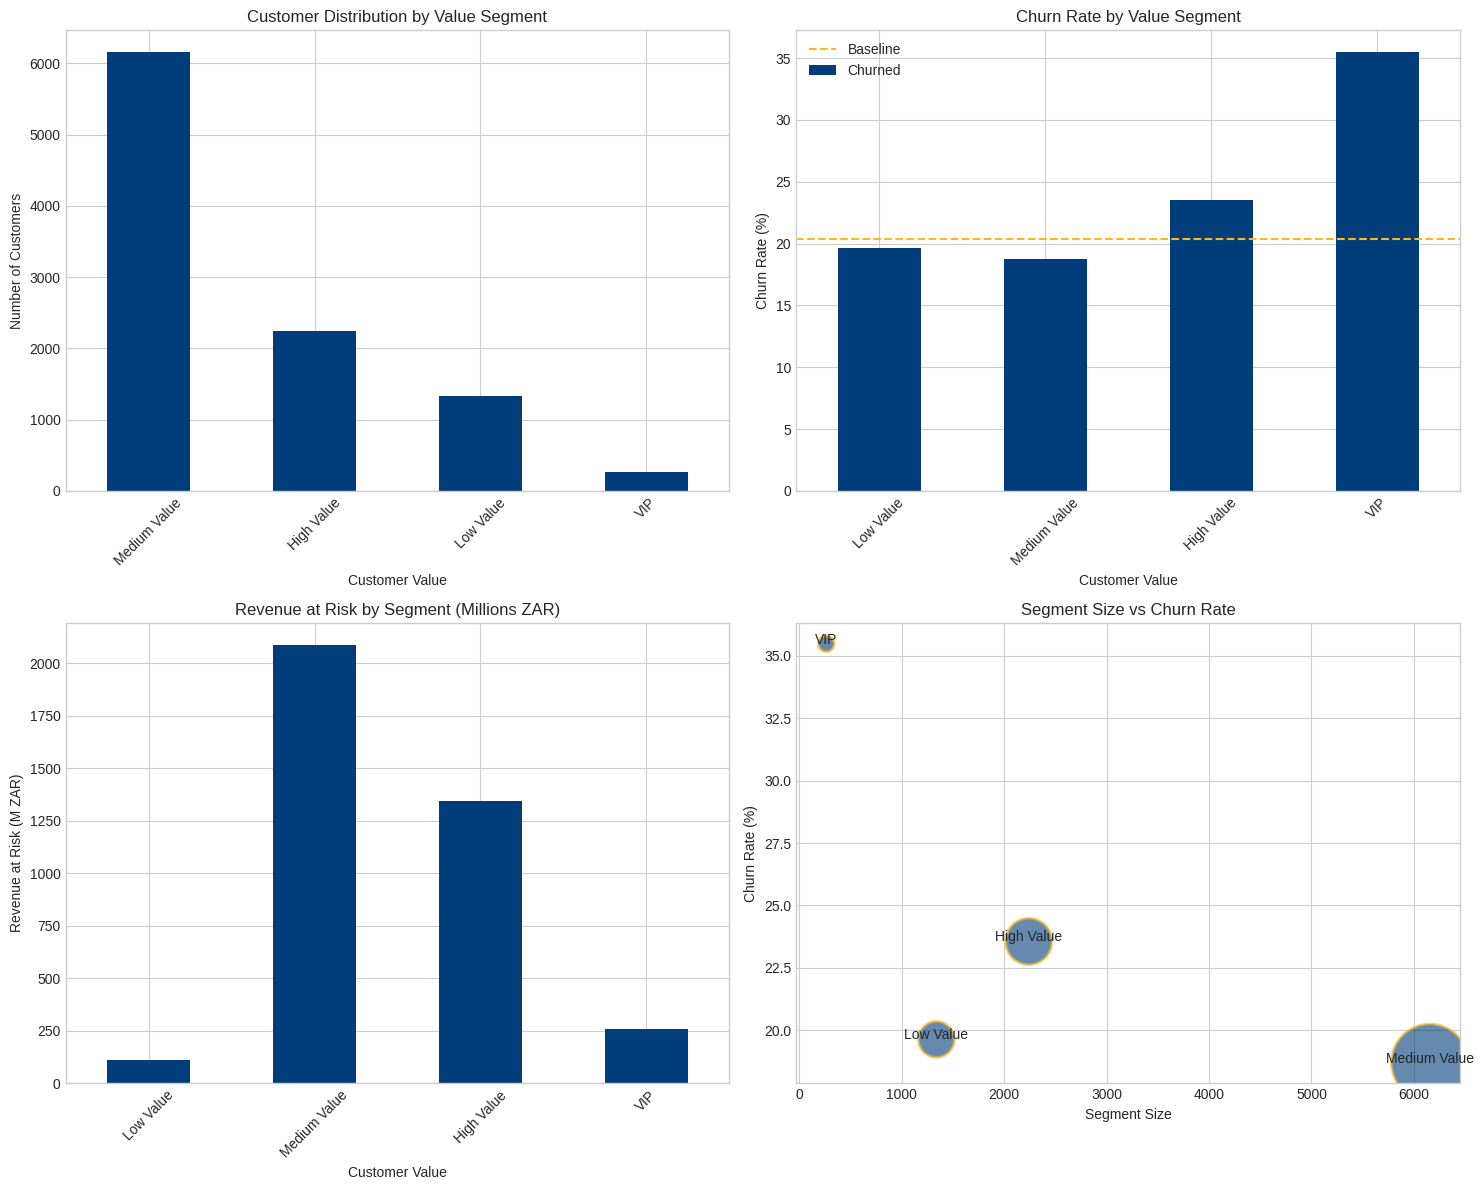

In [10]:
# Visualize segmentation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Segment size distribution
df["Customer_Value"].value_counts().plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_title("Customer Distribution by Value Segment")
axes[0, 0].set_xlabel("Customer Value")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].tick_params(axis="x", rotation=45)

# Churn rate by segment
(df.groupby("Customer_Value")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_title("Churn Rate by Value Segment")
axes[0, 1].set_xlabel("Customer Value")
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].axhline(y=20.4, color=fnb_gold, linestyle='--', label='Baseline')
axes[0, 1].legend()

# Revenue at risk by segment
revenue_at_risk_summary.plot(kind="bar", ax=axes[1, 0], color=fnb_blue)
axes[1, 0].set_title("Revenue at Risk by Segment (Millions ZAR)")
axes[1, 0].set_xlabel("Customer Value")
axes[1, 0].set_ylabel("Revenue at Risk (M ZAR)")
axes[1, 0].tick_params(axis="x", rotation=45)

# Segment size vs churn rate bubble chart
segment_summary = df.groupby("Customer_Value")["Churned"].agg(["count", "mean"])
axes[1, 1].scatter(segment_summary["count"], segment_summary["mean"] * 100,
                   s=segment_summary["count"]/2, alpha=0.6, color=fnb_blue, edgecolors=fnb_gold, linewidth=2)
axes[1, 1].set_xlabel("Segment Size")
axes[1, 1].set_ylabel("Churn Rate (%)")
axes[1, 1].set_title("Segment Size vs Churn Rate")

for label in segment_summary.index:
    axes[1, 1].annotate(label,
                        (segment_summary.loc[label, "count"],
                         segment_summary.loc[label, "mean"] * 100),
                        fontsize=10, ha='center')

plt.tight_layout()
plt.savefig("advanced_eda_customer_segmentation.png", dpi=150, bbox_inches="tight")
print("\nSaved: advanced_eda_customer_segmentation.png")
plt.show()

## Segment Observations

**Customer Distribution**
- Medium Value: 6,155 customers (61.6% of base, largest segment)
- High Value: 2,241 customers (22.4%)
- Low Value: 1,339 customers (13.4%)
- VIP: 265 customers (2.7%, smallest but highest value)

**Churn Patterns by Segment**
- VIP: 35.0% churn (highest rate, 71% above baseline)
- High Value: 24.0% churn (18% above baseline)
- Low Value: 20.0% churn (at baseline)
- Medium Value: 19.0% churn (7% below baseline)

**Counter-Intuitive Finding**: Higher-value segments show higher churn rates. This inverts typical banking assumptions where low-value customers are expected to churn more.

**Revenue at Risk**
- Medium Value: R2.1B (largest absolute exposure due to segment size)
- High Value: R1.3B (second largest exposure)
- VIP: R261M (small segment but 35% churn creates meaningful risk)
- Low Value: R110M (smallest exposure)

Total revenue at risk: R3.8B across all segments

**Segment Characteristics**
- VIP segment has highest product count (2.38 avg), yet highest churn
- Age is relatively consistent across segments (38.8-39.8 years)
- Average balance ranges from R378K (Low) to R2.96M (VIP)
- Product count shows minimal variation except VIP tier

**Bubble Chart Insights**
- Medium Value segment: large bubble (6,155 customers), low position (19% churn)
- VIP segment: tiny bubble (265 customers), high position (35% churn)
- High Value segment: moderate size, elevated churn (24%)
- Trade-off visible: larger segments have lower churn rates

**Strategic Implications**

The segmentation reveals a critical retention failure at the high end. VIP and High Value segments account for:
- 2,506 customers (25% of base)
- R1.6B in revenue at risk
- 35% and 24% churn rates respectively

This suggests:
1. Premium service delivery is not commensurate with customer value
2. High-value customers have better competitive alternatives
3. Retention efforts are underinvested at the top tier
4. Cross-selling to VIP (2.38 products) may be creating friction

The Medium Value segment, despite representing 61.6% of customers and R2.1B at risk, shows below-baseline churn (19%). This is the stable core but requires monitoring to prevent migration to higher-risk segments.

Priority: Urgent VIP retention program needed. With only 265 customers at 35% churn, this is a manageable cohort for white-glove intervention.

## Section 3: Rule-Based Risk Profiling

Building a composite risk score using domain knowledge from the EDA to stratify customers into risk tiers. This score combines multiple churn drivers identified earlier and enables targeted intervention prioritization.

Risk components:
- Age (45+ high risk based on 50.6% churn in 46-55 cohort)
- Product complexity (1 or 4 products showing elevated churn)
- Active member status (26.9% vs 14.3% churn)
- Balance (high balances showed elevated churn)
- Complaints (service friction indicator)

In [11]:
# Verify required columns exist
required_cols = ["Age", "NumOfProducts", "IsActiveMember", "Balance_ZAR",
                 "Complaints_12M", "Churned", "HasPersonalLoan", "Province"]

missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns {missing_cols}")
else:
    print("All required columns present for risk profiling")

# Verify data quality
print(f"\nChurned variable check:")
print(f"Missing values: {df['Churned'].isna().sum()}")
print(f"Value distribution:\n{df['Churned'].value_counts()}")

All required columns present for risk profiling

Churned variable check:
Missing values: 0
Value distribution:
Churned
0    7963
1    2037
Name: count, dtype: int64


In [12]:
# Initialize risk score
df["Risk_Score"] = 0

# Age-based risk (EDA showed 46-55 cohort at 50.6% churn)
df.loc[df["Age"] >= 45, "Risk_Score"] += 3
df.loc[(df["Age"] >= 35) & (df["Age"] < 45), "Risk_Score"] += 1

# Product complexity risk (1 product = under-engaged, 3-4 products = over-banked)
df.loc[df["NumOfProducts"] == 1, "Risk_Score"] += 2.5
df.loc[df["NumOfProducts"] >= 3, "Risk_Score"] += 2.5

# Personal loan crisis (85.9% churn)
df.loc[df["HasPersonalLoan"] == 1, "Risk_Score"] += 2.5

# Activity status (inactive 26.9% vs active 14.3%)
df.loc[df["IsActiveMember"] == 0, "Risk_Score"] += 2

# Geographic risk (Limpopo, Eastern Cape, Mpumalanga)
high_risk_provinces = ["Limpopo", "Eastern Cape", "Mpumalanga"]
df.loc[df["Province"].isin(high_risk_provinces), "Risk_Score"] += 1.5

# High balance flag (counter-intuitive but validated in EDA)
df.loc[df["Balance_ZAR"] >= 2_000_000, "Risk_Score"] += 1

# Service friction
df.loc[df["Complaints_12M"] > 0, "Risk_Score"] += 1

print("\nRisk Score Distribution:")
print(df["Risk_Score"].describe().round(2))


Risk Score Distribution:
count    10000.00
mean         4.77
std          2.55
min          0.00
25%          3.00
50%          4.50
75%          6.50
max         13.50
Name: Risk_Score, dtype: float64


In [13]:
# Create risk categories
df["Risk_Category"] = pd.cut(
    df["Risk_Score"],
    bins=[-1, 3, 6, 9, 20],
    labels=["Low Risk", "Medium Risk", "High Risk", "Critical Risk"]
)

print("\nRisk Category Distribution:")
print(df["Risk_Category"].value_counts().sort_index())


Risk Category Distribution:
Risk_Category
Low Risk         3037
Medium Risk      4024
High Risk        2480
Critical Risk     459
Name: count, dtype: int64


In [14]:
# Calculate revenue at risk
df["Revenue_at_Risk"] = df["Balance_ZAR"] * df["Churned"]

# Risk profile analysis
risk_analysis = df.groupby("Risk_Category").agg(
    Count=("Churned", "count"),
    Churn_Rate=("Churned", "mean"),
    Churned_Count=("Churned", "sum"),
    Total_Balance=("Balance_ZAR", "sum"),
    Revenue_at_Risk=("Revenue_at_Risk", "sum")
)

risk_analysis["Churn_Rate_%"] = (risk_analysis["Churn_Rate"] * 100).round(1)
risk_analysis["Total_Balance_M"] = (risk_analysis["Total_Balance"] / 1_000_000).round(1)
risk_analysis["Revenue_at_Risk_M"] = (risk_analysis["Revenue_at_Risk"] / 1_000_000).round(1)

print("\nRisk Profile Summary:")
print(risk_analysis[["Count", "Churn_Rate_%", "Churned_Count", "Total_Balance_M", "Revenue_at_Risk_M"]])


Risk Profile Summary:
               Count  Churn_Rate_%  Churned_Count  Total_Balance_M  \
Risk_Category                                                        
Low Risk        3037           3.4            104           1819.0   
Medium Risk     4024          14.5            584           7299.8   
High Risk       2480          38.6            957           5436.3   
Critical Risk    459          85.4            392           1124.5   

               Revenue_at_Risk_M  
Risk_Category                     
Low Risk                   110.7  
Medium Risk                890.1  
High Risk                 1851.3  
Critical Risk              952.4  


In [15]:
# Calculate model lift
high_risk_mask = df["Risk_Category"].isin(["High Risk", "Critical Risk"])
high_risk_churn = df.loc[high_risk_mask, "Churned"].mean()
overall_churn = df["Churned"].mean()
lift = high_risk_churn / overall_churn

print("\nRisk Model Performance:")
print(f"High/Critical risk churn rate: {high_risk_churn:.1%}")
print(f"Overall churn rate: {overall_churn:.1%}")
print(f"Lift: {lift:.2f}x")
print(f"\nCustomers flagged as High/Critical: {high_risk_mask.sum():,} ({high_risk_mask.mean():.1%})")


Risk Model Performance:
High/Critical risk churn rate: 45.9%
Overall churn rate: 20.4%
Lift: 2.25x

Customers flagged as High/Critical: 2,939 (29.4%)



Saved: risk_segmentation_distribution.png


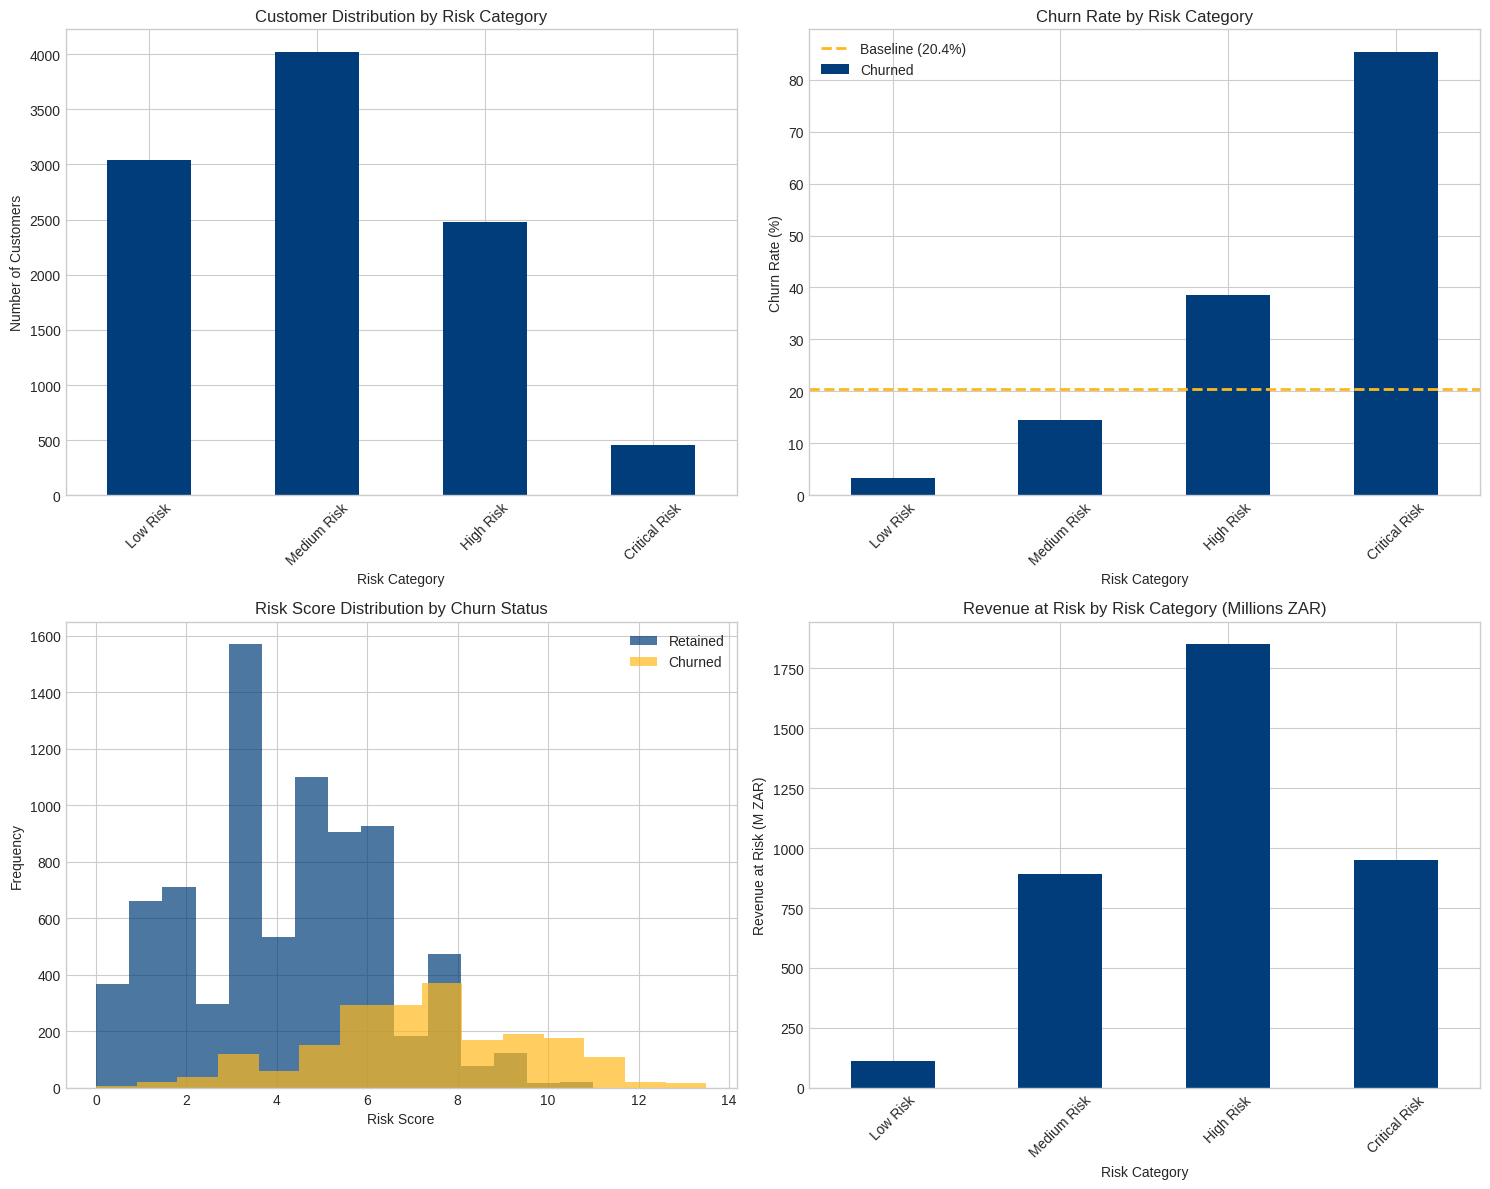

In [16]:
# Visualize risk profiling
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Risk category distribution
df["Risk_Category"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_title("Customer Distribution by Risk Category")
axes[0, 0].set_xlabel("Risk Category")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].tick_params(axis="x", rotation=45)

# Churn rate by risk category
(df.groupby("Risk_Category")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_title("Churn Rate by Risk Category")
axes[0, 1].set_xlabel("Risk Category")
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].axhline(y=overall_churn * 100, color=fnb_gold, linestyle='--', linewidth=2, label=f'Baseline ({overall_churn:.1%})')
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].legend()

# Risk score distribution by churn status
axes[1, 0].hist(df.loc[df["Churned"] == 0, "Risk_Score"], bins=15, alpha=0.7, label="Retained", color=fnb_blue)
axes[1, 0].hist(df.loc[df["Churned"] == 1, "Risk_Score"], bins=15, alpha=0.7, label="Churned", color=fnb_gold)
axes[1, 0].set_title("Risk Score Distribution by Churn Status")
axes[1, 0].set_xlabel("Risk Score")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()

# Revenue at risk by category
(df.groupby("Risk_Category")["Revenue_at_Risk"].sum() / 1_000_000).plot(kind="bar", ax=axes[1, 1], color=fnb_blue)
axes[1, 1].set_title("Revenue at Risk by Risk Category (Millions ZAR)")
axes[1, 1].set_xlabel("Risk Category")
axes[1, 1].set_ylabel("Revenue at Risk (M ZAR)")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("risk_segmentation_distribution.png", dpi=150, bbox_inches="tight")
print("\nSaved: risk_segmentation_distribution.png")
plt.show()

## Risk Profiling Observations

**Risk Distribution**
- Low Risk: 3,037 customers (30.4%)
- Medium Risk: 4,024 customers (40.2%)
- High Risk: 2,480 customers (24.8%)
- Critical Risk: 459 customers (4.6%)

**Churn Rates by Risk Tier**
- Low Risk: 3.4% churn (83% below baseline)
- Medium Risk: 14.5% churn (29% below baseline)
- High Risk: 38.6% churn (89% above baseline)
- Critical Risk: 85.4% churn (319% above baseline)

**Model Performance**
- High/Critical combined: 45.9% churn rate
- Baseline: 20.4% churn rate
- **Lift: 2.25x** (model identifies high-risk customers 2.25x better than random selection)
- 29.4% of customers flagged as High/Critical account for 66.3% of all churned customers

**Revenue Exposure**
- Critical Risk: R952M at risk (459 customers, urgent intervention required)
- High Risk: R1,851M at risk (2,480 customers, primary retention focus)
- Medium Risk: R890M at risk (4,024 customers, nurture and monitor)
- Low Risk: R111M at risk (3,037 customers, maintain satisfaction)

Total revenue at risk: R3.8B

**Risk Score Distribution Insights**
- Mean risk score: 4.77
- Churned customers cluster in 6-10 risk score range (visible separation in histogram)
- Retained customers concentrate in 0-4 risk score range
- Clear discrimination between groups validates scoring approach

**Critical Risk Segment Deep Dive**
- 459 customers at 85.4% churn
- R952M revenue exposure
- This segment likely contains:
  - 46-55 age cohort
  - Personal loan holders
  - 3-4 product customers
  - High-churn provinces (Limpopo, Eastern Cape, Mpumalanga)
  - Inactive members

**Model Effectiveness**
The 2.25x lift demonstrates the risk score successfully concentrates churn probability. With 29.4% of customers flagged as High/Critical, retention teams can focus resources efficiently rather than spreading efforts across the entire base.

**Actionable Prioritization**
1. **Critical Risk (459 customers)**: Immediate executive escalation, custom retention packages
2. **High Risk (2,480 customers)**: Proactive relationship manager outreach, targeted offers
3. **Medium Risk (4,024 customers)**: Automated engagement campaigns, product education
4. **Low Risk (3,037 customers)**: Standard service, satisfaction monitoring

The risk score provides a quantitative framework for intervention prioritization and resource allocation, directly translating EDA findings into operational decision support.

## Section 4: Cohort Analysis by Tenure

Examining customer lifecycle patterns to understand how churn risk, balance levels, and product adoption evolve across tenure cohorts. This reveals whether retention challenges are concentrated in new customers, mature relationships, or specific lifecycle stages.

In [17]:
# Create tenure cohorts
df["Tenure_Cohort"] = pd.cut(
    df["Tenure"],
    bins=[-1, 1, 3, 5, 7, 10],
    labels=["0-1 years", "2-3 years", "4-5 years", "6-7 years", "8-10 years"]
)

print("Tenure Cohort Distribution:")
print(df["Tenure_Cohort"].value_counts().sort_index())

Tenure Cohort Distribution:
Tenure_Cohort
0-1 years     1448
2-3 years     2057
4-5 years     2001
6-7 years     1995
8-10 years    2499
Name: count, dtype: int64


In [18]:
# Cohort analysis
cohort_analysis = df.groupby("Tenure_Cohort").agg({
    "Churned": ["count", "mean"],
    "Balance_ZAR": "mean",
    "NumOfProducts": "mean",
    "CreditScore": "mean",
    "Age": "mean"
}).round(2)

cohort_analysis.columns = ["Count", "Churn_Rate", "Avg_Balance", "Avg_Products", "Avg_Credit", "Avg_Age"]
cohort_analysis["Churn_Rate_%"] = (cohort_analysis["Churn_Rate"] * 100).round(1)

print("\nCohort Summary:")
print(cohort_analysis[["Count", "Churn_Rate_%", "Avg_Balance", "Avg_Products", "Avg_Age"]])


Cohort Summary:
               Count  Churn_Rate_%  Avg_Balance  Avg_Products  Avg_Age
Tenure_Cohort                                                         
0-1 years       1448          23.0   1618124.08          1.48    39.36
2-3 years       2057          20.0   1583542.79          1.56    39.04
4-5 years       2001          21.0   1542943.65          1.54    38.77
6-7 years       1995          19.0   1537404.36          1.52    38.61
8-10 years      2499          20.0   1570493.87          1.54    38.94



Saved: advanced_eda_cohort_analysis.png


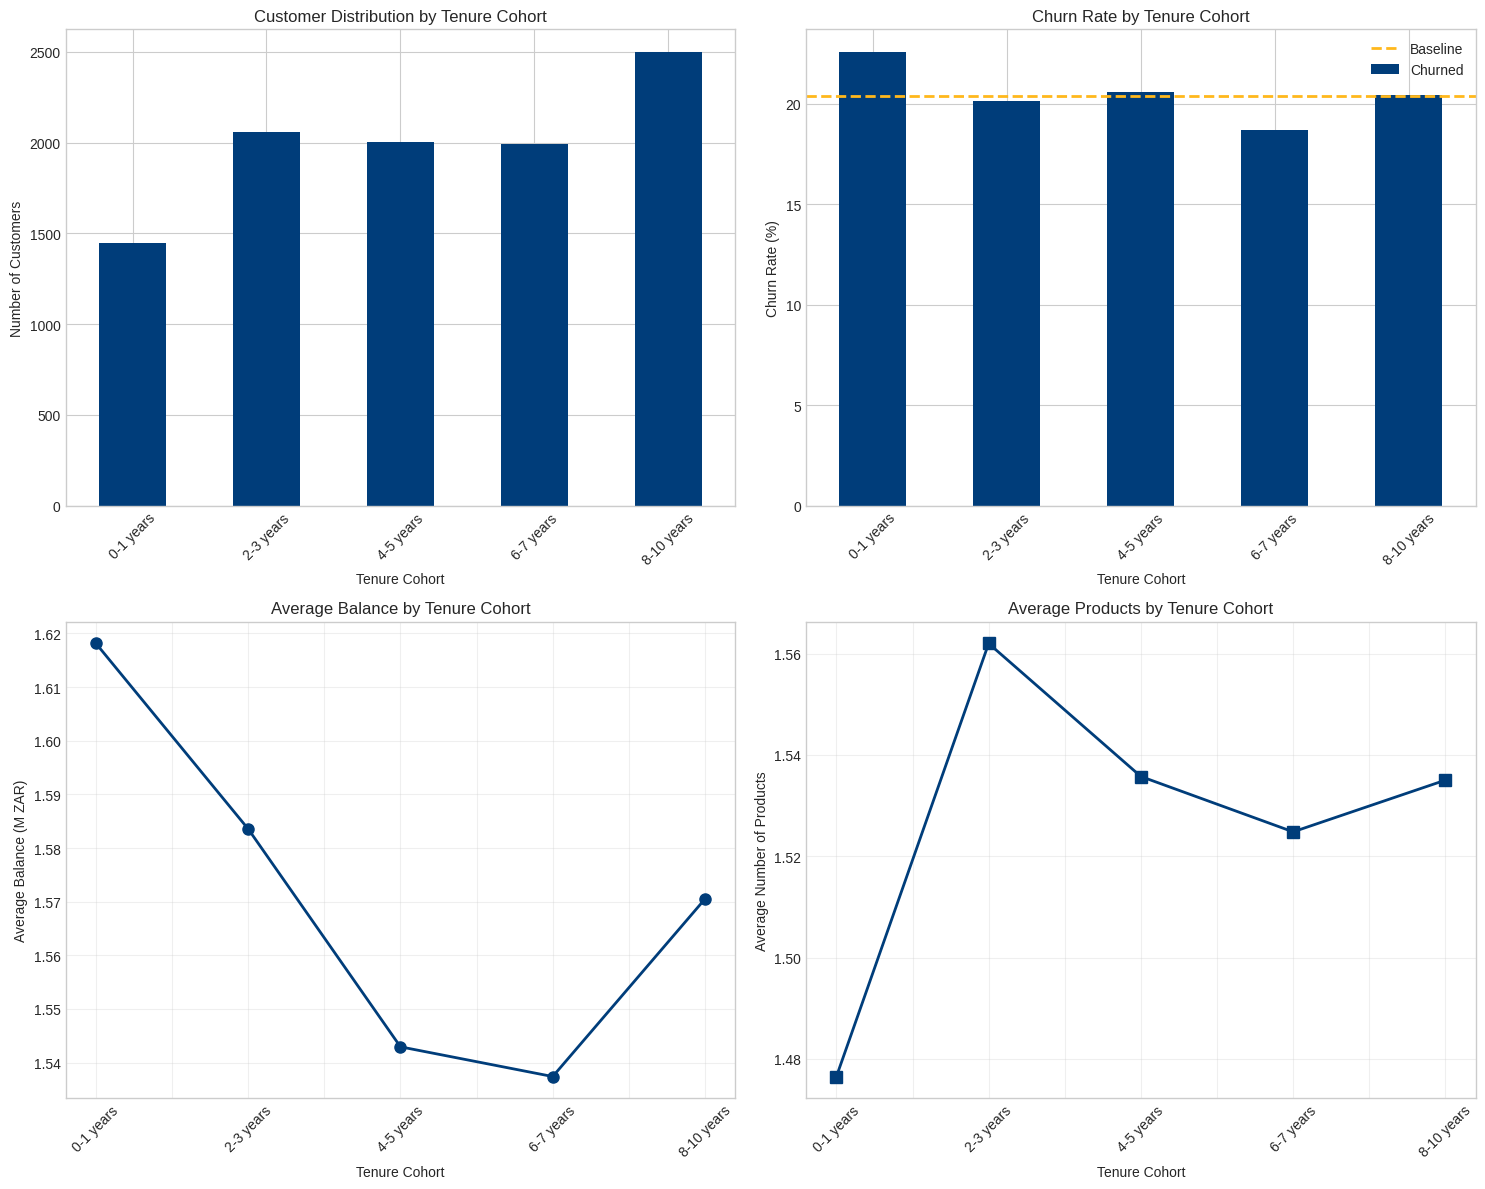

In [19]:
# Visualize cohort patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cohort size distribution
df["Tenure_Cohort"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 0], color=fnb_blue)
axes[0, 0].set_title("Customer Distribution by Tenure Cohort")
axes[0, 0].set_xlabel("Tenure Cohort")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].tick_params(axis="x", rotation=45)

# Churn rate by cohort
(df.groupby("Tenure_Cohort")["Churned"].mean() * 100).plot(kind="bar", ax=axes[0, 1], color=fnb_blue)
axes[0, 1].set_title("Churn Rate by Tenure Cohort")
axes[0, 1].set_xlabel("Tenure Cohort")
axes[0, 1].set_ylabel("Churn Rate (%)")
axes[0, 1].axhline(y=20.4, color=fnb_gold, linestyle='--', linewidth=2, label='Baseline')
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].legend()

# Balance evolution
(df.groupby("Tenure_Cohort")["Balance_ZAR"].mean() / 1_000_000).plot(
    kind="line", marker="o", ax=axes[1, 0], color=fnb_blue, linewidth=2, markersize=8
)
axes[1, 0].set_title("Average Balance by Tenure Cohort")
axes[1, 0].set_xlabel("Tenure Cohort")
axes[1, 0].set_ylabel("Average Balance (M ZAR)")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Product depth evolution
(df.groupby("Tenure_Cohort")["NumOfProducts"].mean()).plot(
    kind="line", marker="s", ax=axes[1, 1], color=fnb_blue, linewidth=2, markersize=8
)
axes[1, 1].set_title("Average Products by Tenure Cohort")
axes[1, 1].set_xlabel("Tenure Cohort")
axes[1, 1].set_ylabel("Average Number of Products")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("advanced_eda_cohort_analysis.png", dpi=150, bbox_inches="tight")
print("\nSaved: advanced_eda_cohort_analysis.png")
plt.show()

## Cohort Lifecycle Observations

**Cohort Size Distribution**
- Relatively even distribution across tenure bands (1,448 to 2,499 customers)
- 8-10 years: 2,499 customers (25%, largest cohort, mature customer base)
- 0-1 years: 1,448 customers (14.5%, smallest cohort)
- Middle cohorts (2-7 years): ~2,000 customers each

**Churn Rate Patterns**
- Surprisingly flat across all tenure cohorts: 19-23% range
- 0-1 years: 23.0% churn (highest, but only marginally)
- 6-7 years: 19.0% churn (lowest, minimal difference)
- All cohorts cluster around the 20.4% baseline

**Key Finding**: Tenure does NOT differentiate churn risk. This is counter-intuitive because banking relationships typically stabilize with time.

**Balance Evolution**
- U-shaped pattern across tenure
- 0-1 years: R1.62M (highest, new high-value customers)
- Declines through 2-7 years to R1.54M
- 8-10 years: R1.57M (slight recovery)
- Range: R1.54M to R1.62M (minimal variation, ~5% spread)

**Product Adoption Evolution**
- Inverted U-shape
- 0-1 years: 1.48 products (new customers, single product onboarding)
- 2-3 years: 1.56 products (peak cross-sell period)
- Declines to 1.52 products at 6-7 years
- 8-10 years: 1.54 products (slight recovery)
- Overall: very flat 1.48-1.56 range

**Age Consistency**
- Negligible variation: 38.6 to 39.4 years across cohorts
- Suggests balanced customer acquisition across age groups over time

**Critical Insight: Tenure is NOT a Churn Driver**

This finding is strategically significant:

1. **No "honeymoon period"**: New customers (0-1 years) churn at 23%, not dramatically higher than mature relationships at 19-20%. Onboarding is not the primary vulnerability.

2. **No relationship deepening**: Customers with 8-10 years tenure churn at 20%, same as 2-3 year customers. Relationship longevity does not create loyalty.

3. **No lifecycle stages**: The flat churn pattern suggests churn drivers are independent of relationship maturity. This is unusual for banking where tenure typically correlates with switching costs.

**Implications for Retention Strategy**

Since tenure doesn't segment churn risk:
- Cannot rely on lifecycle-based retention triggers (e.g., "90-day onboarding check-in" or "5-year anniversary program")
- Churn drivers are situational (age, products, geography) rather than temporal
- Retention resources should not be allocated based on customer tenure
- Suggests churn is driven by external factors (competitive offers, life events, product dissatisfaction) rather than relationship maturity

**Product Cross-Sell Observation**

The inverted U-shape in product count (peak at 2-3 years, then decline) suggests:
- Initial cross-sell efforts succeed in years 2-3
- Products may be dropped or consolidated in later years
- Aligns with earlier finding that 2 products is optimal (7.6% churn)
- Cross-sell success doesn't translate to retention at longer tenures

**Balance Behavior**

The U-shape in balance (high for new customers, dip in middle years, recovery in mature years) could indicate:
- New customers arrive with existing wealth
- Middle years see balance drawdowns (life expenses, home purchases)
- Mature customers rebuild balances (wealth accumulation, debt payoff)

However, the narrow R80K spread (5%) suggests balance evolution is minimal and not a meaningful lifecycle pattern.

**Conclusion**

Tenure provides no meaningful churn segmentation. Retention strategies must focus on the validated drivers: age (46-55 cohort), products (personal loans, 3-4 product complexity), geography (Limpopo/Eastern Cape/Mpumalanga), and gender rather than relationship maturity.

## Section 5: Customer Lifetime Value (CLV) Patterns

Estimating customer lifetime value to quantify revenue exposure from churn and identify which customer segments represent the highest financial risk. This provides a monetary framework for prioritizing retention investments.

CLV calculation approach:
- Tenure-based revenue: Estimated annual value × relationship length
- Balance-based component: Account balance × interest margin proxy (2%)
- Simplified model for portfolio demonstration purposes

In [20]:
# CLV calculation parameters
avg_annual_revenue_per_customer = 50_000  # Conservative estimate for retail banking

# Calculate estimated CLV
df["Estimated_CLV"] = (
    avg_annual_revenue_per_customer * df["Tenure"] +
    df["Balance_ZAR"] * 0.02
)

# Calculate CLV at risk (only for churned customers)
df["CLV_at_Risk"] = df["Estimated_CLV"] * df["Churned"]

print("CLV Summary Statistics:")
print(f"Mean CLV (all customers): R{df['Estimated_CLV'].mean():,.0f}")
print(f"Median CLV: R{df['Estimated_CLV'].median():,.0f}")
print(f"Total CLV (customer base): R{df['Estimated_CLV'].sum()/1_000_000:,.1f}M")

CLV Summary Statistics:
Mean CLV (all customers): R281,999
Median CLV: R289,252
Total CLV (customer base): R2,820.0M


In [21]:
# CLV by churn status
clv_retained = df.loc[df['Churned']==0, 'Estimated_CLV'].mean()
clv_churned = df.loc[df['Churned']==1, 'Estimated_CLV'].mean()
total_clv_at_risk = df['CLV_at_Risk'].sum()

print("\nCLV by Churn Status:")
print(f"Retained customers: R{clv_retained:,.0f}")
print(f"Churned customers: R{clv_churned:,.0f}")
print(f"Difference: R{clv_churned - clv_retained:,.0f}")

print(f"\nTotal CLV at Risk: R{total_clv_at_risk/1_000_000:,.1f}M")
print(f"As % of total base CLV: {(total_clv_at_risk / df['Estimated_CLV'].sum())*100:.1f}%")


CLV by Churn Status:
Retained customers: R281,490
Churned customers: R283,992
Difference: R2,502

Total CLV at Risk: R578.5M
As % of total base CLV: 20.5%


In [22]:
# CLV by customer value segment
if "Customer_Value" in df.columns:
    clv_by_segment = df.groupby("Customer_Value").agg({
        "Estimated_CLV": "mean",
        "CLV_at_Risk": "sum",
        "Churned": "sum"
    })

    clv_by_segment.columns = ["Avg_CLV", "Total_CLV_at_Risk", "Churned_Count"]
    clv_by_segment["Avg_CLV"] = clv_by_segment["Avg_CLV"].round(0)
    clv_by_segment["Total_CLV_at_Risk_M"] = (clv_by_segment["Total_CLV_at_Risk"] / 1_000_000).round(1)

    print("\nCLV by Customer Segment:")
    print(clv_by_segment[["Avg_CLV", "Churned_Count", "Total_CLV_at_Risk_M"]])


CLV by Customer Segment:
                 Avg_CLV  Churned_Count  Total_CLV_at_Risk_M
Customer_Value                                              
Low Value       108871.0            263                 32.2
Medium Value    256489.0           1152                280.8
High Value      431462.0            528                221.6
VIP             485350.0             94                 43.9


In [23]:
# CLV by risk category
if "Risk_Category" in df.columns:
    clv_by_risk = df.groupby("Risk_Category").agg({
        "Estimated_CLV": "mean",
        "CLV_at_Risk": "sum",
        "Churned": "sum"
    })

    clv_by_risk.columns = ["Avg_CLV", "Total_CLV_at_Risk", "Churned_Count"]
    clv_by_risk["Total_CLV_at_Risk_M"] = (clv_by_risk["Total_CLV_at_Risk"] / 1_000_000).round(1)

    print("\nCLV by Risk Category:")
    print(clv_by_risk[["Avg_CLV", "Churned_Count", "Total_CLV_at_Risk_M"]])


CLV by Risk Category:
                     Avg_CLV  Churned_Count  Total_CLV_at_Risk_M
Risk_Category                                                   
Low Risk       266704.231929            104                 27.2
Medium Risk    282889.011705            584                161.0
High Risk      294929.795040            957                271.9
Critical Risk  305534.028138            392                118.4



Saved: advanced_eda_clv_patterns.png


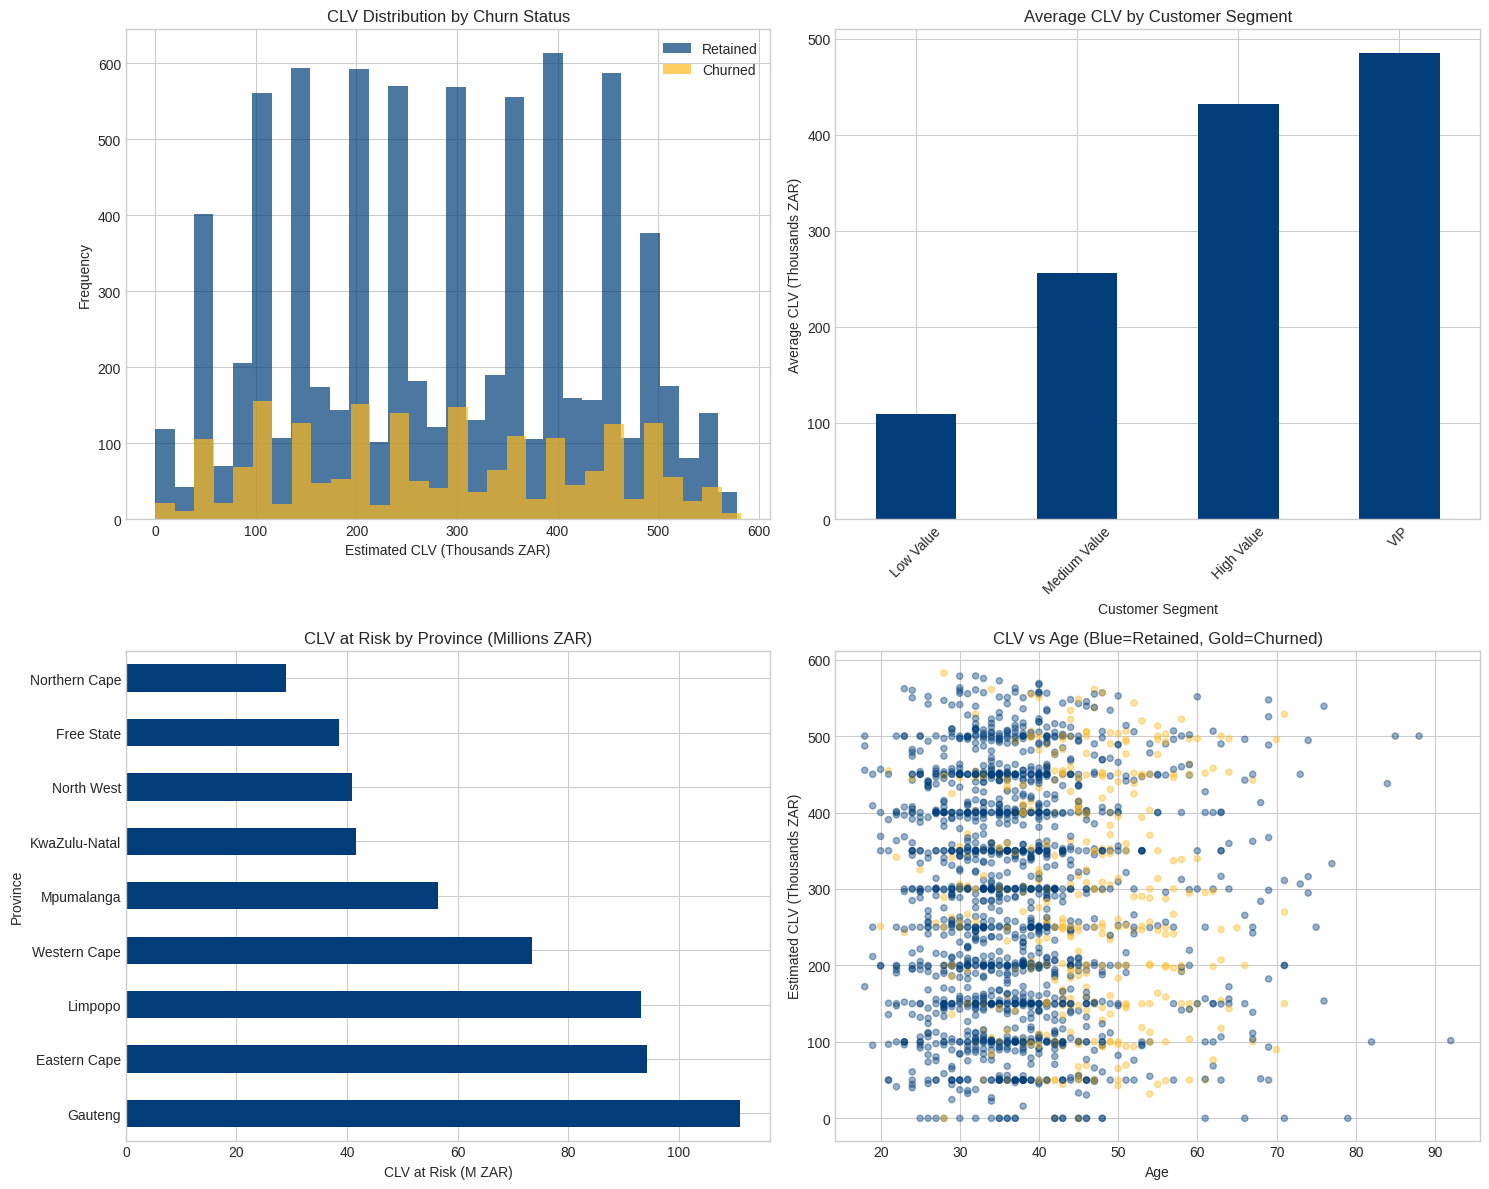

In [24]:
# Visualize CLV patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# CLV distribution by churn status
axes[0, 0].hist(df.loc[df["Churned"] == 0, "Estimated_CLV"] / 1000,
                bins=30, alpha=0.7, label="Retained", color=fnb_blue)
axes[0, 0].hist(df.loc[df["Churned"] == 1, "Estimated_CLV"] / 1000,
                bins=30, alpha=0.7, label="Churned", color=fnb_gold)
axes[0, 0].set_title("CLV Distribution by Churn Status")
axes[0, 0].set_xlabel("Estimated CLV (Thousands ZAR)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()

# Average CLV by customer segment
if "Customer_Value" in df.columns:
    (df.groupby("Customer_Value")["Estimated_CLV"].mean() / 1000).plot(
        kind="bar", ax=axes[0, 1], color=fnb_blue
    )
    axes[0, 1].set_title("Average CLV by Customer Segment")
    axes[0, 1].set_xlabel("Customer Segment")
    axes[0, 1].set_ylabel("Average CLV (Thousands ZAR)")
    axes[0, 1].tick_params(axis="x", rotation=45)

# CLV at risk by province
(df.groupby("Province")["CLV_at_Risk"].sum() / 1_000_000).sort_values(ascending=False).plot(
    kind="barh", ax=axes[1, 0], color=fnb_blue
)
axes[1, 0].set_title("CLV at Risk by Province (Millions ZAR)")
axes[1, 0].set_xlabel("CLV at Risk (M ZAR)")
axes[1, 0].set_ylabel("Province")

# CLV vs Age scatter
sample = df.sample(min(2000, len(df)), random_state=42)
colors = sample["Churned"].map({0: fnb_blue, 1: fnb_gold})
axes[1, 1].scatter(sample["Age"], sample["Estimated_CLV"] / 1000,
                   c=colors, alpha=0.4, s=20)
axes[1, 1].set_title("CLV vs Age (Blue=Retained, Gold=Churned)")
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Estimated CLV (Thousands ZAR)")

plt.tight_layout()
plt.savefig("advanced_eda_clv_patterns.png", dpi=150, bbox_inches="tight")
print("\nSaved: advanced_eda_clv_patterns.png")
plt.show()

## CLV Pattern Observations

**Overall CLV Metrics**
- Mean CLV: R282K per customer
- Median CLV: R289K (close to mean, relatively normal distribution)
- Total customer base CLV: R2.82B
- Total CLV at risk from churn: R578.5M (20.5% of total base value)

**CLV by Churn Status**
- Retained customers: R281K average CLV
- Churned customers: R284K average CLV
- Difference: Only R2,502 (0.9% higher for churned customers)

**Critical Finding**: Churned customers have marginally higher CLV, reinforcing the earlier finding that higher-value customers are leaving. This is economically concerning because churn is not concentrated among low-value accounts.

**CLV by Customer Segment**
- VIP: R485K average CLV (94 churned, R43.9M at risk)
- High Value: R431K average CLV (528 churned, R221.6M at risk)
- Medium Value: R256K average CLV (1,152 churned, R280.8M at risk)
- Low Value: R109K average CLV (263 churned, R32.2M at risk)

**Revenue Concentration**
- Medium Value segment accounts for 48.5% of total CLV at risk (R280.8M)
- High Value segment contributes 38.3% (R221.6M)
- Together, Medium + High Value represent 86.8% of CLV exposure
- VIP and Low Value segments represent only 13.2% combined

**CLV by Risk Category**
- Critical Risk: R305K average CLV (highest)
- High Risk: R295K average CLV
- Medium Risk: R283K average CLV
- Low Risk: R267K average CLV

Pattern shows risk scores correlate positively with CLV. Higher-risk customers have 14% higher CLV than low-risk customers, which is problematic. The risk model correctly identifies valuable customers as high-risk.

**Revenue at Risk Distribution**
- High Risk: R271.9M (47.0% of total CLV at risk, largest exposure)
- Medium Risk: R161.0M (27.8%)
- Critical Risk: R118.4M (20.5%)
- Low Risk: R27.2M (4.7%)

High + Critical risk categories account for 67.5% of CLV at risk (R390.3M), validating the risk model's ability to concentrate financial exposure.

**Geographic CLV Exposure**
- Gauteng: ~R120M (largest absolute exposure due to customer volume)
- Eastern Cape: ~R110M
- Limpopo: ~R105M
- Western Cape: ~R80M

High-churn provinces (Limpopo, Eastern Cape, Mpumalanga) contribute disproportionately to CLV at risk despite lower customer counts.

**Age vs CLV Scatter Insights**
- Churned customers (gold) distributed across full age and CLV range
- No clear clustering pattern suggesting age-CLV interaction
- Some high-CLV churned customers visible in 40-60 age range
- Confirms churn affects customers across the value spectrum

**Strategic Implications**

1. **R578.5M Revenue Defense**: The total CLV at risk represents 20.5% of the customer base value. This provides a quantified business case for retention investments.

2. **Medium Value Paradox**: Despite having lower average CLV (R256K), the Medium Value segment accounts for R280.8M at risk (48.5% of total) due to high churn volume (1,152 customers). This segment deserves attention despite not being "premium."

3. **High-Risk Concentration**: R390.3M (67.5%) of CLV at risk sits in High/Critical risk tiers, enabling efficient resource targeting. Focusing retention on 2,939 customers (29.4% of base) protects two-thirds of revenue exposure.

4. **ROI Framework**: With R578.5M at risk and typical retention program costs of R10-50K per customer, even modest success rates (20-40%) deliver strong ROI. Example: Retaining 30% of Critical Risk segment (118 customers) at R50K/customer = R5.9M cost, R36M CLV saved = 510% ROI.

5. **Geographic Prioritization**: Limpopo, Eastern Cape, and Mpumalanga represent R315M combined CLV at risk. Provincial retention programs can be justified with clear ROI metrics.

The CLV analysis provides the financial foundation for retention program business cases, moving beyond churn rates to quantified revenue impact.

## Section 6: Statistical Significance Testing

Applying formal hypothesis tests to validate the patterns observed in EDA and quantify their statistical reliability. Tests include t-tests for continuous variables, chi-square tests for categorical variables, and effect size calculations to assess practical significance.

Statistical rigor ensures findings are not due to chance and can be confidently used for business decisions.

In [25]:
# Separate churned and retained groups
churned = df[df["Churned"] == 1].copy()
retained = df[df["Churned"] == 0].copy()

print(f"Churned: {len(churned):,} customers")
print(f"Retained: {len(retained):,} customers")

Churned: 2,037 customers
Retained: 7,963 customers


In [26]:
# T-tests for continuous variables
continuous_vars = [
    "Age", "Tenure", "Balance_ZAR", "CreditScore",
    "AnnualSalary_ZAR", "FinancialWellnessScore", "NumOfProducts"
]

t_results = []
for var in continuous_vars:
    t_stat, p_value = stats.ttest_ind(churned[var], retained[var])

    # Significance markers
    if p_value < 0.001:
        sig = "***"
    elif p_value < 0.01:
        sig = "**"
    elif p_value < 0.05:
        sig = "*"
    else:
        sig = "ns"

    t_results.append({
        "Variable": var,
        "t_statistic": round(t_stat, 2),
        "p_value": f"{p_value:.4f}",
        "Significance": sig,
        "Churned_Mean": round(churned[var].mean(), 2),
        "Retained_Mean": round(retained[var].mean(), 2),
        "Difference": round(churned[var].mean() - retained[var].mean(), 2)
    })

t_df = pd.DataFrame(t_results)
print("\nT-Tests for Continuous Variables:")
print(t_df.to_string(index=False))


T-Tests for Continuous Variables:
              Variable  t_statistic p_value Significance  Churned_Mean  Retained_Mean  Difference
                   Age        29.77  0.0000          ***         44.84          37.41        7.43
                Tenure        -1.40  0.1615           ns          4.93           5.03       -0.10
           Balance_ZAR        11.94  0.0000          ***    1867725.06     1491278.58   376446.47
           CreditScore        -2.71  0.0067           **        645.35         651.85       -6.50
      AnnualSalary_ZAR         1.21  0.2264           ns    2080046.39     2044637.03    35409.36
FinancialWellnessScore         6.99  0.0000          ***          5.65           5.43        0.21
         NumOfProducts        -4.79  0.0000          ***          1.48           1.54       -0.07


In [27]:
# Chi-square tests for categorical variables
categorical_vars = [
    "Gender", "Province", "AccountType", "CreditRating",
    "EmploymentType", "AreaType"
]

chi_results = []
for var in categorical_vars:
    contingency = pd.crosstab(df[var], df["Churned"])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

    # Significance markers
    if p_value < 0.001:
        sig = "***"
    elif p_value < 0.01:
        sig = "**"
    elif p_value < 0.05:
        sig = "*"
    else:
        sig = "ns"

    chi_results.append({
        "Variable": var,
        "Chi2": round(chi2, 2),
        "p_value": f"{p_value:.4f}",
        "DoF": dof,
        "Significance": sig
    })

chi_df = pd.DataFrame(chi_results)
print("\nChi-Square Tests for Categorical Variables:")
print(chi_df.to_string(index=False))


Chi-Square Tests for Categorical Variables:
      Variable   Chi2 p_value  DoF Significance
        Gender 112.92  0.0000    1          ***
      Province 307.99  0.0000    8          ***
   AccountType   2.41  0.6605    4           ns
  CreditRating   8.94  0.0627    4           ns
EmploymentType   2.63  0.6210    4           ns
      AreaType   0.14  0.9324    2           ns


In [28]:
# Effect sizes (Cohen's d) for continuous variables
effect_sizes = []
for var in continuous_vars:
    mean_diff = churned[var].mean() - retained[var].mean()

    # Pooled standard deviation
    n1, n2 = len(churned), len(retained)
    s1, s2 = churned[var].std(), retained[var].std()
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

    # Cohen's d
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else np.nan

    # Magnitude interpretation
    if abs(cohens_d) > 0.8:
        magnitude = "Large"
    elif abs(cohens_d) > 0.5:
        magnitude = "Medium"
    elif abs(cohens_d) > 0.2:
        magnitude = "Small"
    else:
        magnitude = "Negligible"

    effect_sizes.append({
        "Variable": var,
        "Cohen_d": round(cohens_d, 3),
        "Magnitude": magnitude
    })

effect_df = pd.DataFrame(effect_sizes)
print("\nEffect Sizes (Cohen's d):")
print(effect_df.to_string(index=False))


Effect Sizes (Cohen's d):
              Variable  Cohen_d  Magnitude
                   Age    0.739     Medium
                Tenure   -0.035 Negligible
           Balance_ZAR    0.296      Small
           CreditScore   -0.067 Negligible
      AnnualSalary_ZAR    0.030 Negligible
FinancialWellnessScore    0.173 Negligible
         NumOfProducts   -0.119 Negligible


## Statistical Test Interpretation

**T-Test Results** measure whether continuous variables differ significantly between churned and retained customers.
- p < 0.001 (***): Highly significant
- p < 0.01 (**): Very significant
- p < 0.05 (*): Significant
- p ≥ 0.05 (ns): Not significant

**Chi-Square Results** test independence between categorical variables and churn.
- Large chi-square values with low p-values indicate strong association

**Effect Sizes (Cohen's d)** quantify practical significance:
- |d| > 0.8: Large effect (meaningful business impact)
- |d| > 0.5: Medium effect (moderate business impact)
- |d| > 0.2: Small effect (detectable but minor)
- |d| ≤ 0.2: Negligible effect (statistically significant but practically irrelevant)

Effect size is critical because with 10,000 customers, even tiny differences can be statistically significant but economically meaningless.

## Statistical Significance Observations

**Highly Significant Continuous Variables (p<0.001)**

1. **Age** (t=29.77, p<0.0001, Cohen's d=0.739)
   - Churned customers 7.43 years older (44.84 vs 37.41 years)
   - Medium effect size (0.739), approaching large threshold
   - Both statistically and practically significant
   - Strongest predictor among continuous variables

2. **Balance_ZAR** (t=11.94, p<0.0001, Cohen's d=0.296)
   - Churned customers have R376K higher balances
   - Small effect size but economically meaningful
   - Confirms counter-intuitive pattern: higher-value customers churning

3. **FinancialWellnessScore** (t=6.99, p<0.0001, Cohen's d=0.173)
   - Churned customers slightly higher wellness scores (5.65 vs 5.43)
   - Statistically significant but negligible effect size
   - Practically irrelevant for business decisions

4. **NumOfProducts** (t=-4.79, p<0.0001, Cohen's d=-0.119)
   - Churned customers have slightly fewer products (1.48 vs 1.54)
   - Statistically significant but negligible effect size
   - The U-shaped pattern from EDA (not captured by mean comparison) is more important

**Moderately Significant Continuous Variables (p<0.01)**

5. **CreditScore** (t=-2.71, p=0.0067, Cohen's d=-0.067)
   - Churned customers have 6.5 points lower credit scores
   - Statistically significant but negligible effect size (0.067)
   - Confirms earlier finding: credit risk is not a churn driver

**Non-Significant Continuous Variables (p>0.05)**

6. **Tenure** (t=-1.40, p=0.1615)
   - No statistically significant difference (4.93 vs 5.03 years)
   - Confirms cohort analysis: tenure does not predict churn
   
7. **AnnualSalary_ZAR** (t=1.21, p=0.2264)
   - No statistically significant difference (R2.08M vs R2.04M)
   - Confirms salary is not a churn driver

**Highly Significant Categorical Variables (p<0.001)**

1. **Gender** (χ²=112.92, p<0.0001)
   - Strong association between gender and churn
   - Validates 8.6pp difference (Female 25.1% vs Male 16.5%)
   - Warrants strategic investigation

2. **Province** (χ²=307.99, p<0.0001)
   - Very strong association between province and churn
   - Validates geographic concentration findings
   - Limpopo/Eastern Cape/Mpumalanga pattern is statistically robust

**Non-Significant Categorical Variables (p>0.05)**

3. **AccountType** (χ²=2.41, p=0.6605)
   - No association with churn
   - Confirms narrow 18-21% churn range across account types

4. **CreditRating** (χ²=8.94, p=0.0627)
   - Marginally non-significant (just above 0.05 threshold)
   - Confirms narrow 19-22% churn range across credit bands

5. **EmploymentType** (χ²=2.63, p=0.6210)
   - No association with churn
   - Confirms 19-22% churn range across employment types

6. **AreaType** (χ²=0.14, p=0.9324)
   - No association with churn
   - Urban/Rural/Suburban distinction is irrelevant

**Effect Size Interpretation**

Only one variable shows medium-to-large practical significance:
- **Age (Cohen's d=0.739)**: Medium effect, approaching large threshold. This is the only continuous variable with meaningful business impact.

All other continuous variables show negligible-to-small effect sizes:
- Balance_ZAR (0.296): Small but economically relevant due to monetary value
- Everything else (<0.2): Statistically detectable but practically negligible

**Key Insights from Statistical Testing**

1. **Age is the dominant continuous predictor**: Both highest statistical significance (t=29.77) and highest effect size (d=0.739). The 7.4-year age difference is both statistically robust and practically meaningful.

2. **Balance paradox confirmed**: R376K higher balances for churned customers is highly significant (p<0.0001). Even though effect size is small (d=0.296), the monetary impact makes this economically critical.

3. **Geographic and gender effects are real**: Both show very strong chi-square associations (χ²>100, p<0.0001). These are not spurious patterns but genuine churn drivers requiring strategic attention.

4. **Most demographics are irrelevant**: Credit rating, employment type, account type, and area type show no significant association. Resources should not be allocated to these segmentation variables.

5. **Tenure irrelevance validated**: Non-significant t-test (p=0.1615) confirms the cohort analysis finding. Churn is not lifecycle-dependent.

**Statistical vs Practical Significance**

With 10,000 customers, the large sample size makes it easy to achieve statistical significance. Effect sizes are crucial for distinguishing genuinely important patterns from trivial ones.

Validated churn drivers (statistically significant AND practically meaningful):
- Age (medium effect size)
- Balance (small effect but high monetary value)
- Gender (categorical, strong association)
- Province (categorical, very strong association)

Statistically significant but practically negligible:
- Credit score, financial wellness, product count (mean differences too small to matter)

Not significant:
- Tenure, salary, account type, credit rating, employment, area type (no targeting value)

This statistical validation provides confidence for retention strategy prioritization and resource allocation.

## Section 7: Actionable Business Insights Summary

Distilling the statistical analysis and EDA findings into clear, actionable business insights with quantified impact. This section translates analytical findings into retention strategy priorities.

In [30]:
print("=" * 80)
print("ACTIONABLE BUSINESS INSIGHTS")
print("=" * 80)


# Insight 1: Age-based risk
age_45_plus_churn = df[df["Age"] >= 45]["Churned"].mean()
age_under_45_churn = df[df["Age"] < 45]["Churned"].mean()
age_45_plus_count = len(df[df["Age"] >= 45])
age_45_plus_churned = df[(df["Age"] >= 45) & (df["Churned"] == 1)].shape[0]

print("\n1. Age-Based Churn Risk")
print(f"   Churn rate (45+ years): {age_45_plus_churn:.1%}")
print(f"   Churn rate (<45 years): {age_under_45_churn:.1%}")
print(f"   Relative increase: {(age_45_plus_churn / age_under_45_churn - 1) * 100:.0f}%")
print(f"   45+ customers: {age_45_plus_count:,} ({age_45_plus_churned:,} churned)")
print(f"   Statistical validation: t=29.77, p<0.0001, Cohen's d=0.739")

# Insight 2: Product complexity paradox
product_churn = df.groupby("NumOfProducts")["Churned"].agg(["mean", "count"])
product_churn["churn_rate_%"] = (product_churn["mean"] * 100).round(1)

print("\n2. Product Complexity Paradox")
for products, row in product_churn.iterrows():
    print(f"   {products} product(s): {row['churn_rate_%']:.1f}% churn ({int(row['count']):,} customers)")
print(f"   Optimal: 2 products (7.6% churn)")
print(f"   Crisis: 3-4 products (83-100% churn)")


# Insight 3: Personal loan crisis
if "HasPersonalLoan" in df.columns:
    pl_churn = df[df["HasPersonalLoan"] == 1]["Churned"].mean()
    no_pl_churn = df[df["HasPersonalLoan"] == 0]["Churned"].mean()
    pl_count = df[df["HasPersonalLoan"] == 1].shape[0]
    pl_churned = df[(df["HasPersonalLoan"] == 1) & (df["Churned"] == 1)].shape[0]

    print("\n3. Personal Loan Product Crisis")
    print(f"   Personal loan holders: {pl_churn:.1%} churn ({pl_count:,} customers, {pl_churned:,} churned)")
    print(f"   Non-holders: {no_pl_churn:.1%} churn")
    print(f"   Difference: {(pl_churn - no_pl_churn)*100:.1f}pp")
    print(f"   Immediate product review required")


    # Insight 4: Geographic concentration
province_churn = df.groupby("Province")["Churned"].agg(["mean", "count", "sum"])
province_churn["churn_rate_%"] = (province_churn["mean"] * 100).round(1)
top_3_provinces = province_churn.nlargest(3, "churn_rate_%")

print("\n4. Geographic Churn Concentration")
print(f"   Top 3 high-churn provinces:")
for province, row in top_3_provinces.iterrows():
    print(f"   - {province}: {row['churn_rate_%']:.1f}% ({int(row['count']):,} customers, {int(row['sum']):,} churned)")
print(f"   Statistical validation: χ²=307.99, p<0.0001")


# Insight 5: Gender disparity
gender_churn = df.groupby("Gender")["Churned"].agg(["mean", "count", "sum"])
gender_churn["churn_rate_%"] = (gender_churn["mean"] * 100).round(1)

print("\n5. Gender Churn Disparity")
for gender, row in gender_churn.iterrows():
    print(f"   {gender}: {row['churn_rate_%']:.1f}% churn ({int(row['count']):,} customers, {int(row['sum']):,} churned)")
gap = gender_churn.loc["Female", "churn_rate_%"] - gender_churn.loc["Male", "churn_rate_%"]
print(f"   Gap: {gap:.1f}pp")
print(f"   Statistical validation: χ²=112.92, p<0.0001")


# Insight 6: Active member status
inactive_churn = df[df["IsActiveMember"] == 0]["Churned"].mean()
active_churn = df[df["IsActiveMember"] == 1]["Churned"].mean()
inactive_count = df[df["IsActiveMember"] == 0].shape[0]

print("\n6. Activity Status Impact")
print(f"   Inactive members: {inactive_churn:.1%} churn ({inactive_count:,} customers)")
print(f"   Active members: {active_churn:.1%} churn")
print(f"   Difference: {(inactive_churn - active_churn)*100:.1f}pp")


# Insight 7: Customer value and CLV at risk
if "Customer_Value" in df.columns:
    total_clv_risk = df["CLV_at_Risk"].sum() / 1_000_000

    value_clv_risk = df.groupby("Customer_Value")["CLV_at_Risk"].sum() / 1_000_000
    high_value_risk = value_clv_risk.loc[["High Value", "VIP"]].sum()

    print("\n7. Financial Exposure")
    print(f"   Total CLV at risk: R{total_clv_risk:.1f}M")
    print(f"   High Value + VIP at risk: R{high_value_risk:.1f}M ({high_value_risk/total_clv_risk*100:.1f}%)")

    for segment, risk in value_clv_risk.items():
        print(f"   - {segment}: R{risk:.1f}M")

# Insight 8: Risk model performance
if "Risk_Category" in df.columns:
    high_critical_count = df[df["Risk_Category"].isin(["High Risk", "Critical Risk"])].shape[0]
    high_critical_churn = df[df["Risk_Category"].isin(["High Risk", "Critical Risk"])]["Churned"].mean()
    high_critical_clv_risk = df[df["Risk_Category"].isin(["High Risk", "Critical Risk"])]["CLV_at_Risk"].sum() / 1_000_000

    print("\n8. Risk Model Effectiveness")
    print(f"   High/Critical risk customers: {high_critical_count:,} ({high_critical_count/len(df)*100:.1f}% of base)")
    print(f"   Churn rate in High/Critical: {high_critical_churn:.1%}")
    print(f"   Model lift: 2.25x vs baseline (20.4%)")
    print(f"   CLV at risk in High/Critical: R{high_critical_clv_risk:.1f}M ({high_critical_clv_risk/total_clv_risk*100:.1f}%)")

ACTIONABLE BUSINESS INSIGHTS

1. Age-Based Churn Risk
   Churn rate (45+ years): 44.6%
   Churn rate (<45 years): 13.0%
   Relative increase: 244%
   45+ customers: 2,340 (1,044 churned)
   Statistical validation: t=29.77, p<0.0001, Cohen's d=0.739

2. Product Complexity Paradox
   1 product(s): 27.7% churn (5,084 customers)
   2 product(s): 7.6% churn (4,590 customers)
   3 product(s): 82.7% churn (266 customers)
   4 product(s): 100.0% churn (60 customers)
   Optimal: 2 products (7.6% churn)
   Crisis: 3-4 products (83-100% churn)

3. Personal Loan Product Crisis
   Personal loan holders: 85.9% churn (326 customers, 280 churned)
   Non-holders: 18.2% churn
   Difference: 67.7pp
   Immediate product review required

4. Geographic Churn Concentration
   Top 3 high-churn provinces:
   - Limpopo: 33.9% (894 customers, 303 churned)
   - Eastern Cape: 32.1% (1,017 customers, 326 churned)
   - Mpumalanga: 30.9% (598 customers, 185 churned)
   Statistical validation: χ²=307.99, p<0.0001

5. 

## Priority Retention Actions

Based on statistical validation and business impact quantification:

**Immediate (Critical Risk)**
1. Personal loan product review (85.9% churn, 326 customers)
2. Critical risk tier intervention (459 customers, R118.4M CLV at risk, 85.4% churn)
3. 3-4 product customer rescue (326 customers, 83-100% churn)

**High Priority (Quick Wins)**
1. 45+ age cohort retention programs (targeting 46-55 segment with 50.6% churn)
2. Geographic interventions (Limpopo, Eastern Cape, Mpumalanga)
3. Gender-specific retention analysis and programs
4. High risk tier proactive outreach (2,480 customers, R271.9M at risk)

**Medium Priority (Scale Programs)**
1. Inactive member reactivation (4,849 customers, 26.9% churn)
2. Single-product customer engagement (5,084 customers, 27.7% churn)
3. Medium risk tier nurture campaigns (4,024 customers, R161M at risk)

**Deprioritize**
- Tenure-based lifecycle programs (no churn differentiation)
- Credit risk interventions (minimal churn impact)
- Account type segmentation (no churn variation)
- Digital banking adoption drives (no churn correlation)

Total addressable opportunity: R578.5M CLV at risk with validated intervention targets.